import numpy.random as random
from astropy import units as u
import matplotlib.patches as patches
def: find_nearest(array, value)
def: powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6)
def: powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4)
def: powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3)
def: powerfuncsingle(hpp,amp1,shift1)
data_dir :  ~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data
data_path :  ~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/processed/luhman_16ab_sector36-37.txt
plot_dir :  ~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/plots
def: find_nearest(array, value)


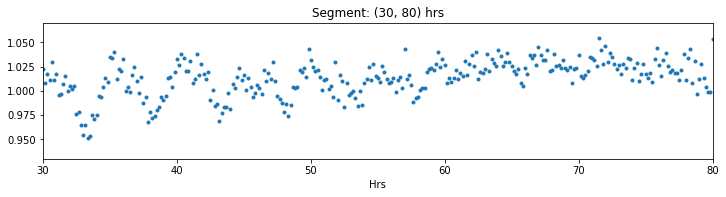

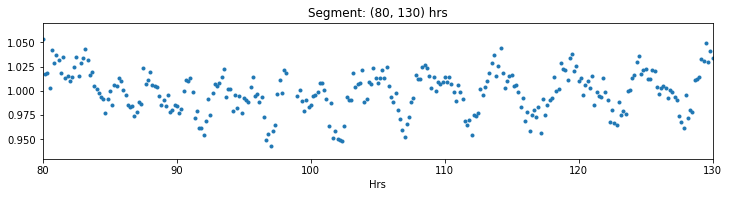

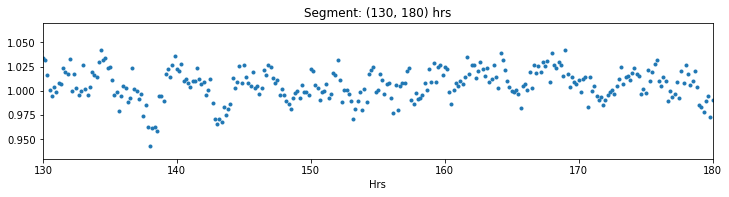

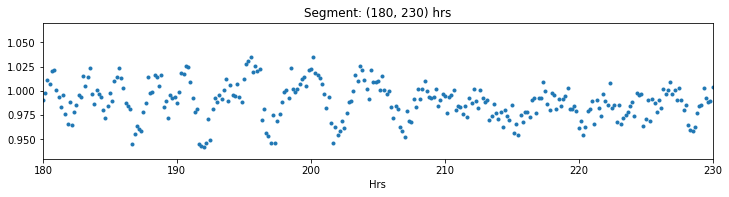

In [1]:
from AROMA import *
from AROMA.utils import *
from AROMA.config import *
import pandas as pd
from scipy.optimize import curve_fit

%matplotlib inline

pi = np.pi 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print('def: find_nearest(array, value)')

import os
from os.path import join
array = os.path.abspath('').split('/')
homedir = '/'
for i in range(1,7):
   homedir = join(homedir, array[i])
homedir

data = pd.read_csv(data_path, header=0, delimiter='\t')
plotPath = join(homedir, 'plots')

# data = data.query('TIME < 2293') # first half of sector 36 
# data = data.query('TIME > 2293 & TIME < 2306') # second half of sector 36 
# data = data.query('TIME < 2306') # full of sector 36

# data = data.query('TIME > 2306 & TIME < 2320') # first half of sector  37 
# data = data.query('TIME > 2320') # second half of sector  37 
# data = data.query('TIME > 2306') # full of sector 37

data = data # full light curve
data.TIME = (data.TIME -data.TIME.iloc[0])*24
fit_dir = join(homedir,'notebooks', 'periodSineFit_metadata')

time, lc = data.TIME, data.PSF_FLUX_NORM
segments = [(30,80), (80,130), (130,180), (180,230)]
for seg in segments:
    plt.figure(figsize=(12, 2.5)), plt.plot(time, lc, ls='', marker='o', ms=3.0), plt.xlim(seg), plt.xlabel('Hrs'), plt.title("Segment: "+str(seg)+" hrs"), plt.ylim((0.93, 1.07))

## Scipy Optimize Linear Regression Fit

Before doing our Markov Chain Monte Carlo (MCMC) Fit, we want to try a simple LR fit first to
1. define good bounds for the priors
2. obtain good guesses for the initial guess

All these will goes into the MCMC fit!

1.0009999950114254
[ 1.11458563e-03 -6.28318446e+00]
[ 0.02753789 -6.28318446]
[ 0.02753784 -5.94184905]
[1.16726817 1.16726823 1.32200599]
[5.38281218 5.38281187 4.75276616] hours


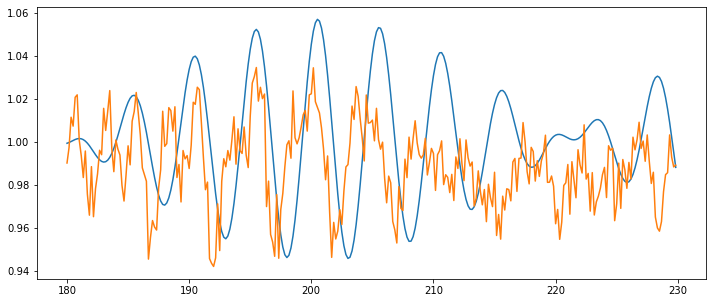

In [73]:
def altmodel(a0, a1, f1, a2, f2, a3, f3, w1, w2, w3, t):
    model = a0 + a1*np.sin(w1*t + f1) + a2*np.sin(w2*t + f2) + a3*np.sin(w3*t + f3)
    return model

tlow, thigh = segments[3]
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
time = np.array(subset.TIME)
lc = np.array(subset.PSF_FLUX_NORM)
lc_err = np.array(subset.PSF_EFLUX)

# guesses=[1, 0.003, 0.5, 0.003, 0.5, 0.003, 0.5, 1.2, 1.2, 1.2]
lim = [(0.99, 1.001), 
       (0, 0.05), (-2*pi, 2*pi), 
       (0, 0.05), (-2*pi, 2*pi), 
       (0, 0.05), (-2*pi, 2*pi), 
       (0.95, 1.4), (0.95, 1.4), (0.95, 1.4)]

popt, pcov = curve_fit(altmodel, time, lc, bounds=np.transpose(lim))
a0, a1, f1, a2, f2, a3, f3, w1, w2, w3 = popt
fit = altmodel(a0, a1, f1, a2, f2, a3, f3, w1, w2, w3, t=time)

plt.figure(figsize=(12,5)), plt.plot(time, fit), plt.plot(time, lc)
print(popt[0])
print(popt[1:3])
print(popt[3:5])
print(popt[5:7])
print(popt[7:10])
print(2*pi/popt[7:10], 'hours')

# emcee Markov Chain Monte Carlo (MCMC)

### Run the LR fit first to obtain `lim` bounds!
Declare four functions:

1. **model()**: The model function should take as an argument a list representing our θ vector, and return the model evaluated at that θ.
2. **lnlike()**: This function takes as an argument theta as well as the x, y, and $y_\text{err}$ of your actual theta. It’s job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points
3. **lnprior()**: This function is to check - before running the probability function on any set of parameters - that all variables are within their priors (in fact, this is where we set our priors). Reasonable bounds on the amplitudes can be drawn from the data (e.g. amplitudes can't be greate than overall signal, periods within expected bounds, no negative amplitudes, etc).
4. **lnprob()**: This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it’s the lnprior output + lnlike output, since lnprior’s output should be zero if the priors are good). lnprob needs to take as arguments theta, x, y, and $y_\text{err}$ since these get passed through to lnlike. 

In [90]:
import emcee

tlow, thigh = segments[3]
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
time = np.array(subset.TIME)
lc = np.array(subset.PSF_FLUX_NORM)
lc_err = np.array(subset.PSF_EFLUX)

df = (time, lc, lc_err)

def model(theta, t=time):
    a1, f1, a2, f2, a3, f3, w1, w2, w3 = theta
    model = a1*np.sin(w1*t + f1) + a2*np.sin(w2*t + f2) + a3*np.sin(w3*t + f3)
    return model

def lnlike(theta, x, y, yerr):
    LnLike = -0.5 * np.sum( (y-model(theta,t=x))/yerr )
    return LnLike

def lnprior(theta, lim=lim):
    a1, f1, a2, f2, a3, f3, w1, w2, w3 = theta
    
    lim = [(0.99, 1.001), 
       (0.001, 0.03), (-10, 10), 
       (0.001, 0.03), (-10, 10), 
       (0.001, 0.03), (-10, 10), 
       (1.15, 1.35), (1.15, 1.35), (1.15, 1.35)]
    # a0
    # a1, f1
    # a2, f2
    # a3, f3
    # w1, w2, w3
    
    # withinbounds = []
    # for i, bound in enumerate(lim):
    #     withinbounds.append(bound[0]<theta[i]<bound[1])
    
    mn, mx = np.array(lim).T
    x = theta[:, None]
    withinbounds = ((x > mn) & (x < mx)).all(1)
    
    if np.all(withinbounds):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

1. We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let’s use 500.
2. We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts). **Foreman-Mackey & Hogg recommend that in many cases, running an optimizer first (e.g., from scipy) is the best way to select an initial starting value.**

Running burn-in...


  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/nguyendat/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.40it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 26.68it/s]


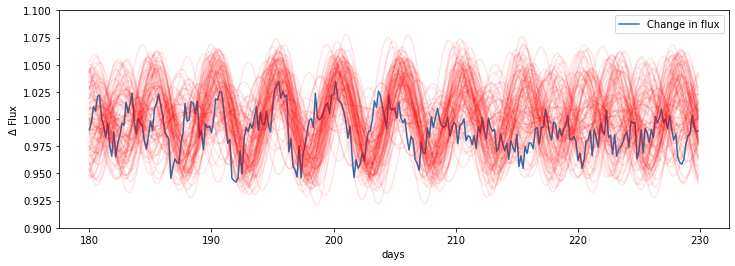

In [123]:
#set nwalkers
nwalkers = 2000
niter = 2000
initial = popt
# initial = [1, 0.003, 0.5, 0.003, 0.5, 0.003, 0.5, 1.2, 1.2, 1.2]
ndim = len(initial)
p0 = [np.array(initial) + 5e-3 * np.random.randn(ndim) for i in range(nwalkers)]

#create initial priors by scipy.optimize

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=df)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,df)

def plotter(sampler,t=time,flux=lc):
    plt.figure(figsize=(12,4))
    plt.plot(t,flux,label='Change in flux')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(t, model(theta, t), color="r", alpha=0.1)
        
    plt.xlabel('days')
    plt.ylabel(r'$\Delta$ Flux')
    plt.legend(), plt.ylim((0.9, 1.1))
    plt.show()
plotter(sampler)

## Now we plot the best fit solution and the prior probability distribution 

Best theta fit
1.005617512863134
[ 2.90841268e-03 -6.27612206e+00]
[ 0.01805179 -6.27863828]
[ 0.02963112 -5.93654584]
[1.172694   1.16378718 1.32310691]
Periods hours:  [5.35790695 5.39891265 4.74881148]


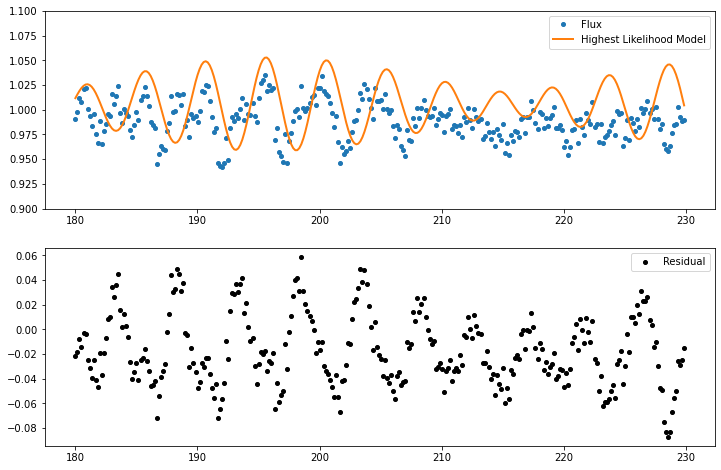

In [124]:
samples = sampler.flatchain

## BEST FIT SOLUTION
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
print('Best theta fit')
print(theta_max[0])
print(theta_max[1:3])
print(theta_max[3:5])
print(theta_max[5:7])
print(theta_max[7:10])
print('Periods hours: ', 2*pi/theta_max[7:10])

best_fit_model = model(theta_max)
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(time,lc,label='Flux',ls='', marker='o', ms=4)
plt.plot(time,best_fit_model,label='Highest Likelihood Model', lw=2)
plt.ylim((0.9, 1.1)), plt.legend()
plt.subplot(212)
plt.plot(time,lc - best_fit_model,label='Residual', ls='', marker='o', ms=4, c='k'), plt.legend()
plt.show()


In [122]:
## CORNER PLOT OF PRIOR PROBABILITY DISTRIBUTION
import corner
labels = ['a0', 'a1', 'f1', 'a2', 'f2', 'a3', 'f3', 'w1', 'w2', 'w3']
p = plt.figure(figsize=(15,15))
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], fig=p)

Error in callback <function flush_figures at 0x7f85fa46cca0> (for post_execute):


KeyboardInterrupt: 